# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2



from IPython.display import display # For interactive figure

# Install DSTAPI to get data from statistikbanken
%pip install git+https://github.com/alemartinello/dstapi
from dstapi import DstApi

# Importen function for plotting interactive figure
#from dataproject import plot_region


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


  Cloning https://github.com/alemartinello/dstapi to c:\users\william gormsen\appdata\local\temp\pip-req-build-2u8mhtze
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi 'C:\Users\William Gormsen\AppData\Local\Temp\pip-req-build-2u8mhtze'


In [18]:
#import and read
pop = DstApi('FRDK123') #Defining the data set
params = pop._define_base_params(language='en') #Language is set to english
pop.tablesummary(language='en') #Getting the table summary


Table FRDK123: Befolkningsfremskrivning 2023 for hele landet efter herkomst, køn, alder og tid
Last update: 2023-06-01T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,HERKOMST,5,999,Personer med dansk oprindelse,35,Efterkommere fra ikke-vestlige lande,False
1,KØN,2,M,Mænd,K,Kvinder,False
2,ALDER,106,0,0 år,105-,105 år og derover,False
3,Tid,48,2023,2023,2070,2070,True


# Read and clean data

In [19]:
import pandas as pd
#Defining the variables we want to use
params = {'table': 'FRDK123',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'HERKOMST', 'values': ['*']},
  {'code': 'KØN', 'values': ['M', 'K']},
  {'code': 'ALDER', 'values': ['>=0<=100']},
  {'code': 'Tid', 'values': ['*']}]}

#Getting the data
datapop_api = pop.get_data(params=params)

# Assuming df is your DataFrame and 'Alder' is the column with the ages
datapop_api['ALDER'] = datapop_api['ALDER'].str.extract('(\d+)').astype(int)

datapop_api.sample(n=10)


,HERKOMST,KØN,ALDER,TID,INDHOLD
18784,Descendants from western countries,Women,62,2035,76
19156,Persons of danish origin,Women,35,2035,29170
28410,Descendants from western countries,Women,0,2051,2600
26791,Descendants from non-western countries,Men,96,2033,0
39249,Immigrants from non-western countries,Women,95,2059,587
34555,Descendants from non-western countries,Men,32,2034,2720
19289,Persons of danish origin,Men,64,2035,30713
33717,Persons of danish origin,Women,96,2051,4691
39099,Immigrants from western countries,Men,50,2059,3304
8710,Persons of danish origin,Men,52,2049,31054


Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

/var/folders/vj/yxjyqsh92md50khx532ch1qh0000gn/T/ipykernel_80422/3145673549.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_df['INDHOLD'] = women_df['INDHOLD'] * -1
/var/folders/vj/yxjyqsh92md50khx532ch1qh0000gn/T/ipykernel_80422/3145673549.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(abs(tick)) for tick in ticks])


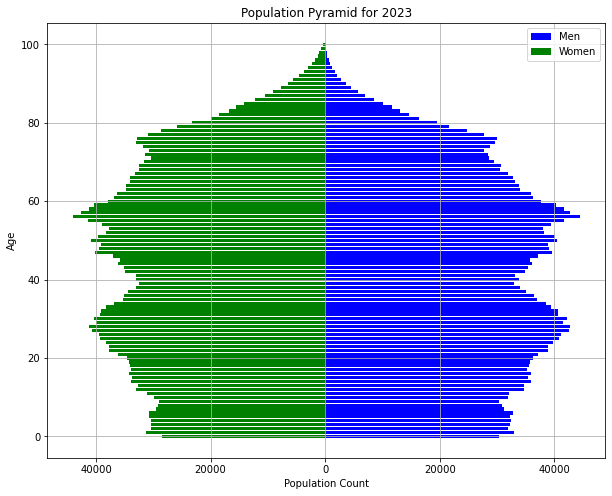

In [7]:
# Since the user has provided a snippet of their code, we will continue from where they left off.
# The user has extracted the age information and converted it to integers.
# Next, we need to filter the DataFrame for the year 2023 and create the age pyramid.

# Filtering the DataFrame for the year 2023 as 'TID' is the column with the year information.
df = datapop_api[datapop_api["TID"] == 2023]

# Now let's prepare the data for the pyramid chart by summing the population counts by age and gender.
# 'HERKOMST' seems not to be relevant for the pyramid plot itself, as we are summing over all origin categories.

# We'll assume 'KØN' has 'M' for Men and 'K' for Women, and 'INDHOLD' is the population count.
# We create two separate DataFrames for men and women.

datapop_df = df.groupby(["KØN", "ALDER"])["INDHOLD"].sum().reset_index()





# Splitting the DataFrame into one for men and one for women.
men_df = datapop_df[datapop_df['KØN'] == 'Men']
women_df = datapop_df[datapop_df['KØN'] == 'Women']

# Since the 'women_df' population counts need to be negative for the pyramid plot, we'll multiply by -1.
women_df['INDHOLD'] = women_df['INDHOLD'] * -1

# Now, we can plot the population pyramid.
fig, ax = plt.subplots(figsize=(10, 8))

# Create the bar plots for men (positive) and women (negative) to create the pyramid effect.
ax.barh(men_df['ALDER'], men_df['INDHOLD'], color='blue', label='Men')
ax.barh(women_df['ALDER'], women_df['INDHOLD'], color='green', label='Women')

# Add labels and title
ax.set_xlabel('Population Count')
ax.set_ylabel('Age')
ax.set_title('Population Pyramid for 2023')

# Positive values on the x-axis
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])

# Adding legends
ax.legend()

# Show grid
ax.grid(True)

# Show the plot
plt.show()

**Interactive plot** :

In [8]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

# Assuming 'datapop_api' is your complete DataFrame with all years ('TID') and 'ALDER' as age.

# This function will update the plot when the slider is changed.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def update_plot(year):
    # Filter the DataFrame for the selected year
    df_year = datapop_api[datapop_api["TID"] == year]
    
    # Group by gender and age, then sum the population count
    age_pyramid_data = df_year.groupby(["KØN", "ALDER"])["INDHOLD"].sum().unstack("KØN")
    
    # Make women's population negative for plotting
    age_pyramid_data['Women'] = -age_pyramid_data['Women']

    # Clear the previous figure and create a new one
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the data
    ax.barh(age_pyramid_data.index, age_pyramid_data['Men'], color='blue', label='Men')
    ax.barh(age_pyramid_data.index, age_pyramid_data['Women'], color='green', label='Women')

    # Set labels and title
    ax.set_xlabel('Population Count')
    ax.set_ylabel('Age')
    ax.set_title(f'Population Pyramid for {year}')
    ax.legend()



    ax.set_ylim(0, age_pyramid_data.index.max())



    # Change y-axis to show only labels for every 5 years.
    # Find the max age to set as the limit for the y-axis ticks.
    # max_age = age_pyramid_data.index.max() + (5 - age_pyramid_data.index.max() % 5)  # Round up to the nearest multiple of 5
    ax.set_yticks(np.arange(0, 101, 5))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure that only integer ticks are shown

    # Set the x-axis to show positive values for both sides
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])

    # Show grid
    ax.grid(True)

    # Display the plot
    plt.show()

# Assuming 'datapop_api' is your DataFrame and 'year_slider' is the IntSlider widget:
# widgets.inter

# Create a slider for the year selection
years = datapop_api['TID'].unique()
year_slider = widgets.IntSlider(min=min(years), max=max(years), step=1, value=min(years), description='Year')

# Display the slider and attach the update function
widgets.interactive(update_plot, year=year_slider)


interactive(children=(IntSlider(value=2023, description='Year', max=2070, min=2023), Output()), _dom_classes=(…

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

<Figure size 720x432 with 0 Axes>

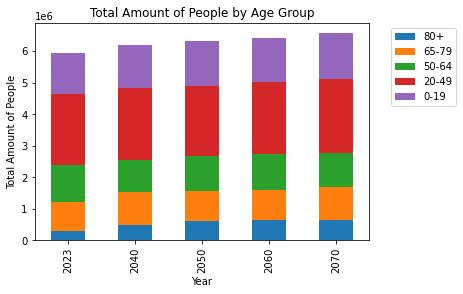

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the age groups and their labels
bins = [0, 20, 50, 65, 80, float('inf')]
labels = ['0-19', '20-49', '50-64', '65-79', '80+']

# Create a new column for the age groups
datapop_api['AgeGroup'] = pd.cut(datapop_api['ALDER'], bins=bins, labels=labels, right=False)

# Filter the dataframe for the selected years
selected_years = [2023, 2040, 2050, 2060, 2070]
datapop_api = datapop_api[datapop_api['TID'].isin(selected_years)]

# Group by year and age group, and calculate the total amount of people
grouped = datapop_api.groupby(['TID', 'AgeGroup']).sum().reset_index()

# Pivot the dataframe so that each age group is a column
pivot = grouped.pivot(index='TID', columns='AgeGroup', values='INDHOLD')

# Reverse the order of the columns
pivot = pivot[labels[::-1]]

# Create a new figure with a specific size
plt.figure(figsize=(10, 6))

# Plot the data
pivot.plot(kind='bar', stacked=True)

plt.title('Total Amount of People by Age Group')
plt.xlabel('Year')
plt.ylabel('Total Amount of People')

# Move the legend to the right side of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

Noter fra forelæsning:
- 2-3 figurer/tabeller
- 